# Horizontal Stress Modeling Using Borehole Acoustic Measurements


## Anisotropic vs Isotropic Models

Borehole acoustic measurements are commonly used to calculate mechanical properties and principal stresses. However, borehole acoustic measurements cannot fully capture rock mechanical properties. Consequently, we make several assumptions to integrate borehole acoustic data with available laboratory and field measurements to make reliable estimations of mechanical properties and stresses.
One main assumption is related to mechanical properties anisotropy. Vertical Transverse Isotropic (VTI) models are a simple and effective way to represent anisotropic properties of thinly laminated media such as shales. However, conventional borehole acoustic measurements are not enough to build these VTI models and isotropic models are a common practice. In general, assuming isotropic properties along vertical wells implies underestimation of mechanical properties. Depending on how stress measurements are integrated with isotropic mechanical properties, we can overestimate or underestimate principal horizontal stresses along a column.
This notebook discusses how isotropic models affect estimated parameters from VTI intervals used for geomechanical purposes. We analyze how this underestimation affects estimation of some mechanical parameters and whether we observe under/overestimation or negligible changes.

Main assumptions here: Elastic media. No dynamic-to-static corrections performed.

(This notebook is still under development)

### Imported libraries

In [1]:
import math                                               # basic calculations like square root
import numpy as np                                        # arrays and matrix math
import matplotlib.pyplot as plt                           # plotting

### Functions

In [2]:
# Young and Poisson modulus from Cij modules
def VTI_YoungPoisson(C11,C13,C33,C66):
    C12=C11-2*C66
    Eh=((C11-C12)*(C33*(C11+C12)-2*C13**2))/(C11*C33-C13**2)
    Ev=C33-2*C13**2/(C11+C12)
    PRv=(C12*C33-C13**2)/(C11*C33-C13**2)
    PRh=C13/(C12+C11)
    Ehp=Eh/(1-PRv**2)
    Evp=Ev/(1-PRv**2) #Plane strain modulus
    return Eh, Ev, PRv, PRh, Ehp, Evp
# Horizontal and vertical Biot Moduli
def Biot_Moduli(C11,C13,C33,C66,Ks):
    C12=C11-2*C66
    Biotv=1-(2*C13+C33)/(3*Ks)
    Bioth=1-(C11+C12+C13)/(3*Ks)
    return Biotv, Bioth
# Tectonic strain estimation (using Horizontal Stresses equation)
def Tect_Strains(refpoint,C11,C13,C33,C66,SV,PP,Bioth,Biotv,Shmin,Shmax):
    C11=C11[refpoint]
    C13=C13[refpoint]
    C66=C66[refpoint]
    C33=C33[refpoint]
    SV=SV[refpoint]
    PP=PP[refpoint]
    Bioth=Bioth[refpoint]
    Biotv=Biotv[refpoint]
    K0=(C13/C33)*(SV-Biotv*PP)+Bioth*PP
    K1=C11-C13**2/C33
    K2=-2*C66
    TSMax=(K1*(Shmax-K0)-(K1+K2)*(Shmin-K0))/(K1**2-(K1+K2)**2)
    TSmin=(Shmin-K0-TSMax*(K1+K2))/K1
    return TSMax, TSmin
# Horizontal Stresses
def Horizontal_Stresses(C11,C13,C33,C66,SV,PP,BiotH,BiotV,Tsmin,TSMax):
    Shmin=(C13/C33)*(SV-PP*BiotV)+(C11-C13**2/C33)*(TSMax+Tsmin)-2*C66*TSMax+PP*BiotH
    SHMax=(C13/C33)*(SV-PP*BiotV)+(C11-C13**2/C33)*(TSMax+Tsmin)-2*C66*Tsmin+PP*BiotH
    return Shmin, SHMax

### Case 1. Stress calibration at isotropic layers
This case has four layers. Two are isotropic and two VTI.
The stress measurement point is located at an isotropic interval.

#### Defining rock mechanical properties
We generate a synthetic model to use as reference. We call it TRUE model.
We use stiffness coefficients to define mechanical properties at each layer.

Useful reference here: https://dnicolasespinoza.github.io/node13.html

In [3]:
#All properties are in MPa
C11=[72394.98, 51710.7, 31991.6864,37921.8]
C33=[72394.98, 37714.3372, 31991.6864,25634.71768]
C13=[36542.228, 13444.782, 8549.5024,5233.12284]
C44=[17926.376, 13297.4152, 11721.092,10542.08804]
C66=[17926.376, 17269.98806, 11721.092,15168.472]
KS=76.8e9*0.00014504
#Depths are in m
Log_Depth=np.arange(2000,2120.5,0.5)
Log_C11=np.zeros(len(Log_Depth))
Log_C33=np.zeros(len(Log_Depth))
Log_C13=np.zeros(len(Log_Depth))
Log_C44=np.zeros(len(Log_Depth))
Log_C66=np.zeros(len(Log_Depth))
for n in range(len(Log_Depth)):
    if Log_Depth[n]<2030.5:
        Log_C11[n]=C11[0]
        Log_C13[n]=C13[0]
        Log_C33[n]=C33[0]
        Log_C44[n]=C44[0]
        Log_C66[n]=C66[0]
    elif Log_Depth[n]<2060.5:
        Log_C11[n]=C11[1]
        Log_C13[n]=C13[1]
        Log_C33[n]=C33[1]
        Log_C44[n]=C44[1]
        Log_C66[n]=C66[1]
    elif Log_Depth[n]<2090.5:
        Log_C11[n]=C11[2]
        Log_C13[n]=C13[2]
        Log_C33[n]=C33[2]
        Log_C44[n]=C44[2]
        Log_C66[n]=C66[2]
    else:
        Log_C11[n]=C11[3]
        Log_C13[n]=C13[3]
        Log_C33[n]=C33[3]
        Log_C44[n]=C44[3]
        Log_C66[n]=C66[3]

#### Isotropic model
We calculate the isotropic (ISO) model from our TRUE model.
In vertical wells, we can only measure C33 and C44. These two parameters are enough to build an isotropic model.
The figure below illustrates the underestimation of mechanical properties when compairing stiffness coefficients.

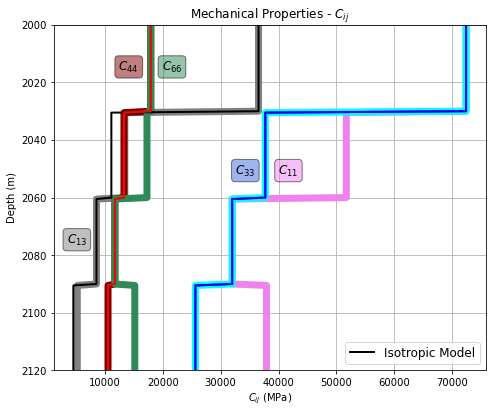

In [4]:
#Isotropic -> C11=C33, C66=C44, C13=C33-2C44
LogIso_C11=Log_C33
LogIso_C33=Log_C33
LogIso_C66=Log_C44
LogIso_C44=Log_C44
LogIso_C13=Log_C33-2*Log_C44

fig, ax = plt.subplots()
plt.plot(Log_C11,Log_Depth,'violet',linewidth=7)
plt.plot(Log_C33,Log_Depth,'cyan',linewidth=7)
plt.plot(Log_C13,Log_Depth,'gray',linewidth=7)
plt.plot(Log_C44,Log_Depth,'maroon',linewidth=7)
plt.plot(Log_C66,Log_Depth,'seagreen',linewidth=7)
props = dict(boxstyle='round', facecolor='violet', alpha=0.5)
ax.text(0.52, 0.6, '$C_{11}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)
props = dict(boxstyle='round', facecolor='royalblue', alpha=0.5)
ax.text(0.42, 0.6, '$C_{33}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)
props = dict(boxstyle='round', facecolor='gray', alpha=0.5)
ax.text(0.03, 0.4, '$C_{13}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)
props = dict(boxstyle='round', facecolor='maroon', alpha=0.5)
ax.text(0.15, 0.9, '$C_{44}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)
props = dict(boxstyle='round', facecolor='seagreen', alpha=0.5)
ax.text(0.25, 0.9, '$C_{66}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)

plt.plot(LogIso_C11,Log_Depth,'purple',linewidth=2)
plt.plot(LogIso_C33,Log_Depth,'blue',linewidth=2)
plt.plot(LogIso_C13,Log_Depth,'black',label='Isotropic Model',linewidth=2)
plt.plot(LogIso_C66,Log_Depth,'green',linewidth=2)
plt.plot(LogIso_C44,Log_Depth,'red',linewidth=2)

plt.legend(fontsize=12)
plt.grid()
plt.title('Mechanical Properties - $C_{ij}$')
plt.xlabel('$C_{ij}$ (MPa)'); plt.ylabel('Depth (m)')
plt.ylim(max(Log_Depth), min(Log_Depth))
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.2, wspace=0.5, hspace=0.5)
plt.savefig('MechanicalPropertiesCij.png',bbox_inches='tight')

#### Practical implications
Usage of isotropic model has different effects on parameters used for geomechanical purposes.
This figure shows that underestimation from to isottropic models implies low error when calculatin Ep parameter (Plane Strain Modulus). This Ep parameter is commonly used to estimate mechanical properties of rock during propagation of vertical fractures (Reference: https://dnicolasespinoza.github.io/node56.html#SECTION00832100000000000000).

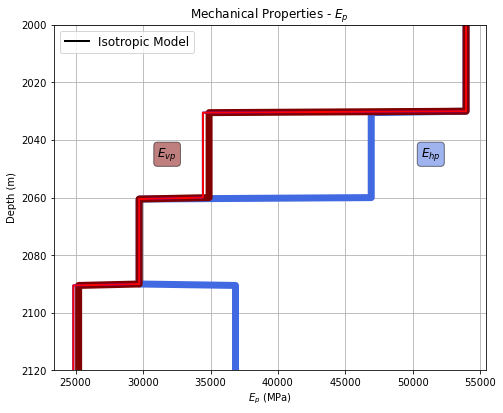

In [5]:
[Log_Eh,Log_Ev,Log_PRv,Log_PRh,Log_Ehp,Log_Evp]=VTI_YoungPoisson(Log_C11,Log_C13,Log_C33,Log_C66)
[LogIso_Eh,LogIso_Ev,LogIso_PRv,LogIso_PRh,LogIso_Ehp,LogIso_Evp]=VTI_YoungPoisson(LogIso_C11,LogIso_C13,LogIso_C33,LogIso_C66)


fig, ax = plt.subplots()
plt.plot(Log_Ehp,Log_Depth,'royalblue',linewidth=7)
plt.plot(Log_Evp,Log_Depth,'maroon',linewidth=7)
props = dict(boxstyle='round', facecolor='royalblue', alpha=0.5)
ax.text(0.85, 0.65, '$E_{hp}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)
props = dict(boxstyle='round', facecolor='maroon', alpha=0.5)
ax.text(0.24, 0.65, '$E_{vp}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)

plt.plot(LogIso_Ehp,Log_Depth,'blue',linewidth=2)
plt.plot(LogIso_Evp,Log_Depth,'red',linewidth=2)
plt.plot(LogIso_Evp*np.nan,Log_Depth,'black',label='Isotropic Model',linewidth=2)

plt.legend(fontsize=12,labelcolor='black')
plt.grid()
plt.title('Mechanical Properties - $E_{p}$')
plt.xlabel('$E_{p}$ (MPa)'); plt.ylabel('Depth (m)')

plt.ylim(max(Log_Depth), min(Log_Depth))
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.2, wspace=0.5, hspace=0.5)
plt.savefig('MechanicalPropertiesYoungModuli.png',bbox_inches='tight')

Isotropic assumptions impact the calculation of Biot coefficient. This coefficient controls the effect of pore pressure during the calculation of horizontal stresses.

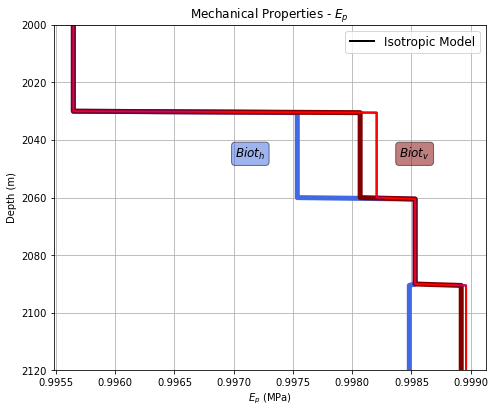

In [6]:
[Log_BiotV,Log_BiotH]=Biot_Moduli(Log_C11,Log_C13,Log_C33,Log_C66,KS)
[LogIso_BiotV,LogIso_BiotH]=Biot_Moduli(LogIso_C11,LogIso_C13,LogIso_C33,LogIso_C66,KS)
fig, ax = plt.subplots()
plt.plot(Log_BiotH,Log_Depth,'royalblue',linewidth=5)
plt.plot(Log_BiotV,Log_Depth,'maroon',linewidth=5)
props = dict(boxstyle='round', facecolor='royalblue', alpha=0.5)
ax.text(0.42, 0.65, '$Biot_{h}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)
props = dict(boxstyle='round', facecolor='maroon', alpha=0.5)
ax.text(0.8, 0.65, '$Biot_{v}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)

plt.plot(LogIso_BiotH,Log_Depth,'blue',linewidth=2)
plt.plot(LogIso_BiotV,Log_Depth,'red',linewidth=2)
plt.plot(LogIso_BiotV*np.nan,Log_Depth,'black',label='Isotropic Model',linewidth=2)

plt.ylim(max(Log_Depth), min(Log_Depth))
plt.legend(fontsize=12,labelcolor='black')
plt.grid()
plt.title('Mechanical Properties - $E_{p}$')
plt.xlabel('$E_{p}$ (MPa)'); plt.ylabel('Depth (m)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.2, wspace=0.5, hspace=0.5)
plt.savefig('MechanicalPropertiesBiot.png',bbox_inches='tight')

To model the implication on horizontal stresses calculation we build first a model based on the TRUE model parameters and then we reconstruct it using ISO model parameters. We do this for multiple tectonic environments: Passive, Active with Low tectonic stress Anisotropy (LA) and Active with High tectonic stress Anisotropy (HA)

In [7]:
SVatTop=47 #MPa
SV_Gradient=0.02352 #MPa/m
PPSVRatio=0.7
Calibrationpoint_index=151
# Calibrationpoint_index=31

Log_SV=SVatTop+SV_Gradient*(Log_Depth-Log_Depth[0])
Log_PP=Log_SV*PPSVRatio

PassiveShmin=40
PassiveShmax=45
ActiveLAShmin=45
ActiveLAShmax=50
ActiveHAShmin=45
ActiveHAShmax=65

[Passive_TSMax,Passive_TSmin]=Tect_Strains(Calibrationpoint_index,Log_C11,Log_C13,Log_C33,Log_C66,Log_SV,Log_PP,Log_BiotH,Log_BiotV,PassiveShmin,PassiveShmax)
[ActiveLA_TSMax,ActiveLA_TSmin]=Tect_Strains(Calibrationpoint_index,Log_C11,Log_C13,Log_C33,Log_C66,Log_SV,Log_PP,Log_BiotH,Log_BiotV,ActiveLAShmin,ActiveLAShmax)
[ActiveHA_TSMax,ActiveHA_TSmin]=Tect_Strains(Calibrationpoint_index,Log_C11,Log_C13,Log_C33,Log_C66,Log_SV,Log_PP,Log_BiotH,Log_BiotV,ActiveHAShmin,ActiveHAShmax)

[PassiveIso_TSMax,PassiveIso_TSmin]=Tect_Strains(Calibrationpoint_index,LogIso_C11,LogIso_C13,LogIso_C33,LogIso_C66,Log_SV,Log_PP,LogIso_BiotH,LogIso_BiotV,PassiveShmin,PassiveShmax)
[ActiveLAIso_TSMax,ActiveLAIso_TSmin]=Tect_Strains(Calibrationpoint_index,LogIso_C11,LogIso_C13,LogIso_C33,LogIso_C66,Log_SV,Log_PP,LogIso_BiotH,LogIso_BiotV,ActiveLAShmin,ActiveLAShmax)
[ActiveHAIso_TSMax,ActiveHAIso_TSmin]=Tect_Strains(Calibrationpoint_index,LogIso_C11,LogIso_C13,LogIso_C33,LogIso_C66,Log_SV,Log_PP,LogIso_BiotH,LogIso_BiotV,ActiveHAShmin,ActiveHAShmax)

[Log_PassiveShmin,Log_PassiveSHMax]=Horizontal_Stresses(Log_C11,Log_C13,Log_C33,Log_C66,Log_SV,Log_PP,Log_BiotH,Log_BiotV,Passive_TSmin,Passive_TSMax)
[Log_ActiveLAShmin,Log_ActiveLASHMax]=Horizontal_Stresses(Log_C11,Log_C13,Log_C33,Log_C66,Log_SV,Log_PP,Log_BiotH,Log_BiotV,ActiveLA_TSmin,ActiveLA_TSMax)
[Log_ActiveHAShmin,Log_ActiveHASHMax]=Horizontal_Stresses(Log_C11,Log_C13,Log_C33,Log_C66,Log_SV,Log_PP,Log_BiotH,Log_BiotV,ActiveHA_TSmin,ActiveHA_TSMax)

[Log_PassiveIsoShmin,Log_PassiveIsoSHMax]=Horizontal_Stresses(LogIso_C11,LogIso_C13,LogIso_C33,LogIso_C66,Log_SV,Log_PP,LogIso_BiotH,LogIso_BiotV,PassiveIso_TSmin,PassiveIso_TSMax)
[Log_ActiveLAIsoShmin,Log_ActiveLAIsoSHMax]=Horizontal_Stresses(LogIso_C11,LogIso_C13,LogIso_C33,LogIso_C66,Log_SV,Log_PP,LogIso_BiotH,LogIso_BiotV,ActiveLAIso_TSmin,ActiveLAIso_TSMax)
[Log_ActiveHAIsoShmin,Log_ActiveHAIsoSHMax]=Horizontal_Stresses(LogIso_C11,LogIso_C13,LogIso_C33,LogIso_C66,Log_SV,Log_PP,LogIso_BiotH,LogIso_BiotV,ActiveHAIso_TSmin,ActiveHAIso_TSMax)

Figures show that isotropic model underestimate horizontal stresses calculation along VTI intervals when stress calibration points are only located along isotropic intervals.

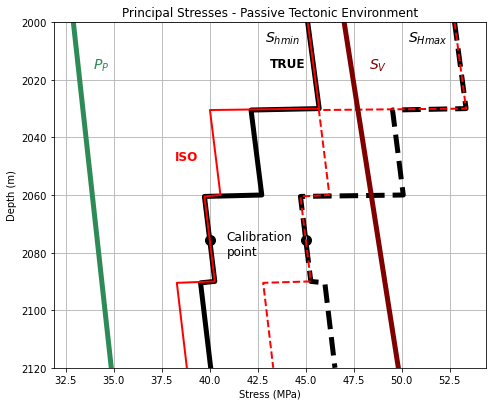

In [8]:
fig, ax = plt.subplots()
plt.plot(Log_PassiveShmin,Log_Depth,'black',linewidth=5)
plt.plot(Log_PassiveSHMax,Log_Depth,'black',linewidth=5,linestyle='dashed')
ax.text(0.5, 0.9, 'TRUE', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',weight='bold')

plt.plot(Log_PassiveIsoShmin,Log_Depth,'red',linewidth=2)
plt.plot(Log_PassiveIsoSHMax,Log_Depth,'red',linewidth=2,linestyle='dashed')
ax.text(0.28, 0.63, 'ISO', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='red',weight='bold')

plt.scatter(PassiveShmin,Log_Depth[Calibrationpoint_index],color='black',s=100)
plt.scatter(PassiveShmax,Log_Depth[Calibrationpoint_index],color='black',s=100)

plt.plot(Log_SV,Log_Depth,'maroon',label='Elastic',linewidth=5)
plt.plot(Log_PP,Log_Depth,'seagreen',label='Elastic',linewidth=5)
ax.text(0.73, 0.9, '$S_{V}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='maroon',weight='bold')
ax.text(0.09, 0.9, '$P_{P}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='seagreen',weight='bold')
ax.text(0.49, 0.98, '$S_{hmin}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='black')
ax.text(0.82, 0.98, '$S_{Hmax}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='black')
ax.text(0.4, 0.4, '{}\n{}'.format('Calibration','point'), transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black')

plt.ylim(max(Log_Depth), min(Log_Depth))
plt.grid()
plt.title('Principal Stresses - Passive Tectonic Environment')
plt.xlabel('Stress (MPa)'); plt.ylabel('Depth (m)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.2, wspace=0.5, hspace=0.5)

Analysis under active tectonic environments shows that tectonic environments and principal stresses underestimation is possible as well.

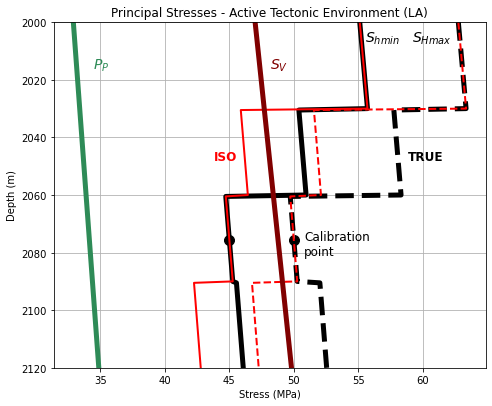

In [9]:
fig, ax = plt.subplots()
plt.plot(Log_ActiveLAShmin,Log_Depth,'black',linewidth=5)
plt.plot(Log_ActiveLASHMax,Log_Depth,'black',linewidth=5,linestyle='dashed')
ax.text(0.82, 0.63, 'TRUE', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',weight='bold')

plt.plot(Log_ActiveLAIsoShmin,Log_Depth,'red',linewidth=2)
plt.plot(Log_ActiveLAIsoSHMax,Log_Depth,'red',linewidth=2,linestyle='dashed')
ax.text(0.37, 0.63, 'ISO', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='red',weight='bold')

plt.scatter(ActiveLAShmin,Log_Depth[Calibrationpoint_index],color='black',s=100)
plt.scatter(ActiveLAShmax,Log_Depth[Calibrationpoint_index],color='black',s=100)

plt.plot(Log_SV,Log_Depth,'maroon',label='Elastic',linewidth=5)
plt.plot(Log_PP,Log_Depth,'seagreen',label='Elastic',linewidth=5)
ax.text(0.5, 0.9, '$S_{V}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='maroon',weight='bold')
ax.text(0.09, 0.9, '$P_{P}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='seagreen',weight='bold')
ax.text(0.72, 0.98, '$S_{hmin}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='black')
ax.text(0.83, 0.98, '$S_{Hmax}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='black')
ax.text(0.58, 0.4, '{}\n{}'.format('Calibration','point'), transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black')
plt.grid()
plt.ylim(max(Log_Depth), min(Log_Depth))
plt.title('Principal Stresses - Active Tectonic Environment (LA)')
plt.xlabel('Stress (MPa)'); plt.ylabel('Depth (m)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.2, wspace=0.5, hspace=0.5)

This effects are present both for LA and HA.

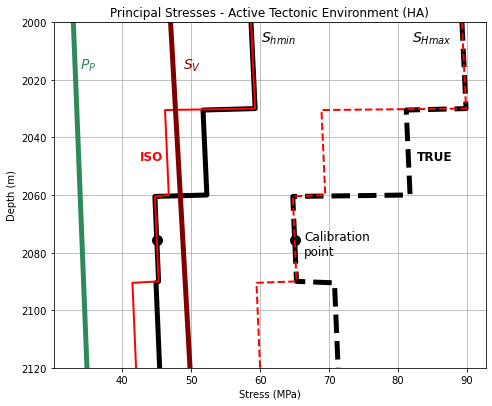

In [10]:
fig, ax = plt.subplots()
plt.plot(Log_ActiveHAShmin,Log_Depth,'black',linewidth=5)
plt.plot(Log_ActiveHASHMax,Log_Depth,'black',linewidth=5,linestyle='dashed')
ax.text(0.84, 0.63, 'TRUE', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',weight='bold')

plt.plot(Log_ActiveHAIsoShmin,Log_Depth,'red',linewidth=2)
plt.plot(Log_ActiveHAIsoSHMax,Log_Depth,'red',linewidth=2,linestyle='dashed')
ax.text(0.2, 0.63, 'ISO', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='red',weight='bold')

plt.scatter(ActiveHAShmin,Log_Depth[Calibrationpoint_index],color='black',s=100)
plt.scatter(ActiveHAShmax,Log_Depth[Calibrationpoint_index],color='black',s=100)

plt.plot(Log_SV,Log_Depth,'maroon',label='Elastic',linewidth=5)
plt.plot(Log_PP,Log_Depth,'seagreen',label='Elastic',linewidth=5)
ax.text(0.3, 0.9, '$S_{V}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='maroon',weight='bold')
ax.text(0.06, 0.9, '$P_{P}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='seagreen',weight='bold')
ax.text(0.48, 0.98, '$S_{hmin}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='black')
ax.text(0.83, 0.98, '$S_{Hmax}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='black')
ax.text(0.58, 0.4, '{}\n{}'.format('Calibration','point'), transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black')
plt.grid()
plt.ylim(max(Log_Depth), min(Log_Depth))
plt.title('Principal Stresses - Active Tectonic Environment (HA)')
plt.xlabel('Stress (MPa)'); plt.ylabel('Depth (m)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.2, wspace=0.5, hspace=0.5)

### Case 2. Stress calibration at VTI layers
This case has three layers. One is isotropic and two VTI.
The stress measurement point is located at a VTI interval.

#### Defining rock mechanical properties
First I define the TRUE model.

In [11]:
#All properties are in MPa
C11=[47142.9215,  51710.7,34473.8]
C33=[47142.9215,  37714.3372,23304.2888]
C13=[12324.7164,  13444.782,4757.3844]
C44=[17409.269,  13297.4152,9583.7164]
C66=[17409.269,  17269.98806,13789.52]
KS=76.8e9*0.00014504
#Depths are in m
Log_Depth=np.arange(2000,2120.5,0.5)
Log_C11=np.zeros(len(Log_Depth))
Log_C33=np.zeros(len(Log_Depth))
Log_C13=np.zeros(len(Log_Depth))
Log_C44=np.zeros(len(Log_Depth))
Log_C66=np.zeros(len(Log_Depth))
for n in range(len(Log_Depth)):
    if Log_Depth[n]<2040.5:
        Log_C11[n]=C11[0]
        Log_C13[n]=C13[0]
        Log_C33[n]=C33[0]
        Log_C44[n]=C44[0]
        Log_C66[n]=C66[0]
    elif Log_Depth[n]<2080.5:
        Log_C11[n]=C11[1]
        Log_C13[n]=C13[1]
        Log_C33[n]=C33[1]
        Log_C44[n]=C44[1]
        Log_C66[n]=C66[1]
    else:
        Log_C11[n]=C11[2]
        Log_C13[n]=C13[2]
        Log_C33[n]=C33[2]
        Log_C44[n]=C44[2]
        Log_C66[n]=C66[2]

#### Isotropic model

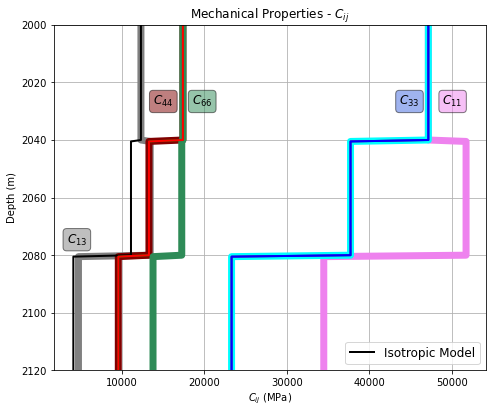

In [12]:
#Isotropic -> C11=C33, C66=C44, C13=C33-2C44
LogIso_C11=Log_C33
LogIso_C33=Log_C33
LogIso_C66=Log_C44
LogIso_C44=Log_C44
LogIso_C13=Log_C33-2*Log_C44

fig, ax = plt.subplots()
plt.plot(Log_C11,Log_Depth,'violet',linewidth=7)
plt.plot(Log_C33,Log_Depth,'cyan',linewidth=7)
plt.plot(Log_C13,Log_Depth,'gray',linewidth=7)
plt.plot(Log_C44,Log_Depth,'maroon',linewidth=7)
plt.plot(Log_C66,Log_Depth,'seagreen',linewidth=7)
props = dict(boxstyle='round', facecolor='violet', alpha=0.5)
ax.text(0.9, 0.8, '$C_{11}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)
props = dict(boxstyle='round', facecolor='royalblue', alpha=0.5)
ax.text(0.8, 0.8, '$C_{33}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)
props = dict(boxstyle='round', facecolor='gray', alpha=0.5)
ax.text(0.03, 0.4, '$C_{13}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)
props = dict(boxstyle='round', facecolor='maroon', alpha=0.5)
ax.text(0.23, 0.8, '$C_{44}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)
props = dict(boxstyle='round', facecolor='seagreen', alpha=0.5)
ax.text(0.32, 0.8, '$C_{66}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)

plt.plot(LogIso_C11,Log_Depth,'purple',linewidth=2)
plt.plot(LogIso_C33,Log_Depth,'blue',linewidth=2)
plt.plot(LogIso_C13,Log_Depth,'black',label='Isotropic Model',linewidth=2)
plt.plot(LogIso_C66,Log_Depth,'green',linewidth=2)
plt.plot(LogIso_C44,Log_Depth,'red',linewidth=2)

plt.legend(fontsize=12)
plt.grid()
plt.title('Mechanical Properties - $C_{ij}$')
plt.xlabel('$C_{ij}$ (MPa)'); plt.ylabel('Depth (m)')
plt.ylim(max(Log_Depth), min(Log_Depth))
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.2, wspace=0.5, hspace=0.5)
plt.savefig('MechanicalPropertiesCij.png',bbox_inches='tight')

#### Practical implications
This figure shows that underestimation from to isotropic models implies low error when calculating Evp parameter.

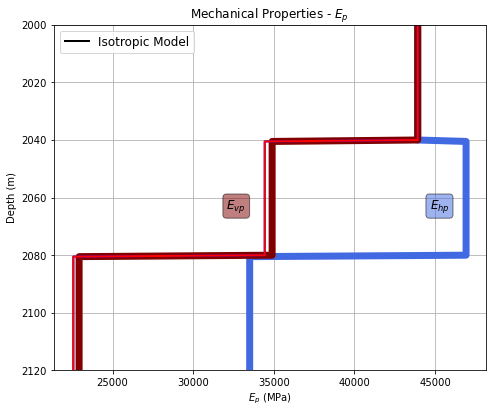

In [13]:
[Log_Eh,Log_Ev,Log_PRv,Log_PRh,Log_Ehp,Log_Evp]=VTI_YoungPoisson(Log_C11,Log_C13,Log_C33,Log_C66)
[LogIso_Eh,LogIso_Ev,LogIso_PRv,LogIso_PRh,LogIso_Ehp,LogIso_Evp]=VTI_YoungPoisson(LogIso_C11,LogIso_C13,LogIso_C33,LogIso_C66)


fig, ax = plt.subplots()
plt.plot(Log_Ehp,Log_Depth,'royalblue',linewidth=7)
plt.plot(Log_Evp,Log_Depth,'maroon',linewidth=7)
props = dict(boxstyle='round', facecolor='royalblue', alpha=0.5)
ax.text(0.87, 0.5, '$E_{hp}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)
props = dict(boxstyle='round', facecolor='maroon', alpha=0.5)
ax.text(0.4, 0.5, '$E_{vp}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)

plt.plot(LogIso_Ehp,Log_Depth,'blue',linewidth=2)
plt.plot(LogIso_Evp,Log_Depth,'red',linewidth=2)
plt.plot(LogIso_Evp*np.nan,Log_Depth,'black',label='Isotropic Model',linewidth=2)

plt.legend(fontsize=12,labelcolor='black')
plt.grid()
plt.title('Mechanical Properties - $E_{p}$')
plt.xlabel('$E_{p}$ (MPa)'); plt.ylabel('Depth (m)')

plt.ylim(max(Log_Depth), min(Log_Depth))
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.2, wspace=0.5, hspace=0.5)
plt.savefig('MechanicalPropertiesYoungModuli.png',bbox_inches='tight')

Isotropic assumptions impact the calculation of Biot coefficient. This coefficient controls the effect of pore pressure during the calculation of horizontal stresses.

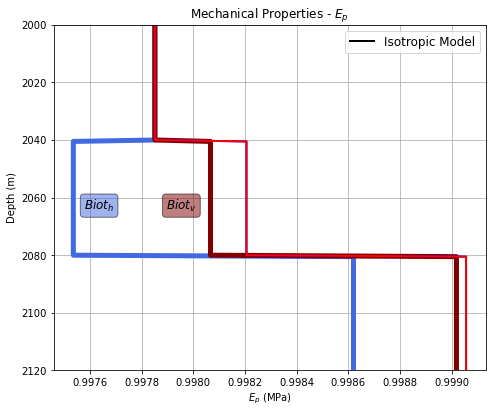

In [14]:
[Log_BiotV,Log_BiotH]=Biot_Moduli(Log_C11,Log_C13,Log_C33,Log_C66,KS)
[LogIso_BiotV,LogIso_BiotH]=Biot_Moduli(LogIso_C11,LogIso_C13,LogIso_C33,LogIso_C66,KS)
fig, ax = plt.subplots()
plt.plot(Log_BiotH,Log_Depth,'royalblue',linewidth=5)
plt.plot(Log_BiotV,Log_Depth,'maroon',linewidth=5)
props = dict(boxstyle='round', facecolor='royalblue', alpha=0.5)
ax.text(0.07, 0.5, '$Biot_{h}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)
props = dict(boxstyle='round', facecolor='maroon', alpha=0.5)
ax.text(0.26, 0.5, '$Biot_{v}$', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',bbox=props)

plt.plot(LogIso_BiotH,Log_Depth,'blue',linewidth=2)
plt.plot(LogIso_BiotV,Log_Depth,'red',linewidth=2)
plt.plot(LogIso_BiotV*np.nan,Log_Depth,'black',label='Isotropic Model',linewidth=2)

plt.ylim(max(Log_Depth), min(Log_Depth))
plt.legend(fontsize=12,labelcolor='black')
plt.grid()
plt.title('Mechanical Properties - $E_{p}$')
plt.xlabel('$E_{p}$ (MPa)'); plt.ylabel('Depth (m)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.2, wspace=0.5, hspace=0.5)
plt.savefig('MechanicalPropertiesBiot.png',bbox_inches='tight')

To model the implication on horizontal stresses calculation we build first a model based on the TRUE model parameters and then we reconstruct it using ISO model parameters. We do this for multiple tectonic environments: Passive, Active with Low tectonic stress Anisotropy (LA) and Active with High tectonic stress Anisotropy (HA)

In [15]:
SVatTop=47 #MPa
SV_Gradient=0.02352 #MPa/m
PPSVRatio=0.7
Calibrationpoint_index=120

Log_SV=SVatTop+SV_Gradient*(Log_Depth-Log_Depth[0])
Log_PP=Log_SV*PPSVRatio

PassiveShmin=40
PassiveShmax=45
ActiveLAShmin=45
ActiveLAShmax=50
ActiveHAShmin=45
ActiveHAShmax=65

[Passive_TSMax,Passive_TSmin]=Tect_Strains(Calibrationpoint_index,Log_C11,Log_C13,Log_C33,Log_C66,Log_SV,Log_PP,Log_BiotH,Log_BiotV,PassiveShmin,PassiveShmax)
[ActiveLA_TSMax,ActiveLA_TSmin]=Tect_Strains(Calibrationpoint_index,Log_C11,Log_C13,Log_C33,Log_C66,Log_SV,Log_PP,Log_BiotH,Log_BiotV,ActiveLAShmin,ActiveLAShmax)
[ActiveHA_TSMax,ActiveHA_TSmin]=Tect_Strains(Calibrationpoint_index,Log_C11,Log_C13,Log_C33,Log_C66,Log_SV,Log_PP,Log_BiotH,Log_BiotV,ActiveHAShmin,ActiveHAShmax)

[PassiveIso_TSMax,PassiveIso_TSmin]=Tect_Strains(Calibrationpoint_index,LogIso_C11,LogIso_C13,LogIso_C33,LogIso_C66,Log_SV,Log_PP,LogIso_BiotH,LogIso_BiotV,PassiveShmin,PassiveShmax)
[ActiveLAIso_TSMax,ActiveLAIso_TSmin]=Tect_Strains(Calibrationpoint_index,LogIso_C11,LogIso_C13,LogIso_C33,LogIso_C66,Log_SV,Log_PP,LogIso_BiotH,LogIso_BiotV,ActiveLAShmin,ActiveLAShmax)
[ActiveHAIso_TSMax,ActiveHAIso_TSmin]=Tect_Strains(Calibrationpoint_index,LogIso_C11,LogIso_C13,LogIso_C33,LogIso_C66,Log_SV,Log_PP,LogIso_BiotH,LogIso_BiotV,ActiveHAShmin,ActiveHAShmax)

[Log_PassiveShmin,Log_PassiveSHMax]=Horizontal_Stresses(Log_C11,Log_C13,Log_C33,Log_C66,Log_SV,Log_PP,Log_BiotH,Log_BiotV,Passive_TSmin,Passive_TSMax)
[Log_ActiveLAShmin,Log_ActiveLASHMax]=Horizontal_Stresses(Log_C11,Log_C13,Log_C33,Log_C66,Log_SV,Log_PP,Log_BiotH,Log_BiotV,ActiveLA_TSmin,ActiveLA_TSMax)
[Log_ActiveHAShmin,Log_ActiveHASHMax]=Horizontal_Stresses(Log_C11,Log_C13,Log_C33,Log_C66,Log_SV,Log_PP,Log_BiotH,Log_BiotV,ActiveHA_TSmin,ActiveHA_TSMax)

[Log_PassiveIsoShmin,Log_PassiveIsoSHMax]=Horizontal_Stresses(LogIso_C11,LogIso_C13,LogIso_C33,LogIso_C66,Log_SV,Log_PP,LogIso_BiotH,LogIso_BiotV,PassiveIso_TSmin,PassiveIso_TSMax)
[Log_ActiveLAIsoShmin,Log_ActiveLAIsoSHMax]=Horizontal_Stresses(LogIso_C11,LogIso_C13,LogIso_C33,LogIso_C66,Log_SV,Log_PP,LogIso_BiotH,LogIso_BiotV,ActiveLAIso_TSmin,ActiveLAIso_TSMax)
[Log_ActiveHAIsoShmin,Log_ActiveHAIsoSHMax]=Horizontal_Stresses(LogIso_C11,LogIso_C13,LogIso_C33,LogIso_C66,Log_SV,Log_PP,LogIso_BiotH,LogIso_BiotV,ActiveHAIso_TSmin,ActiveHAIso_TSMax)

Figures show that isotropic model overestimate horizontal stresses calculation along isotropic intervals when stress calibration points are only located along VTI intervals. Bias along other VTI intervals is lower compared to the one observed for the isotropic section.

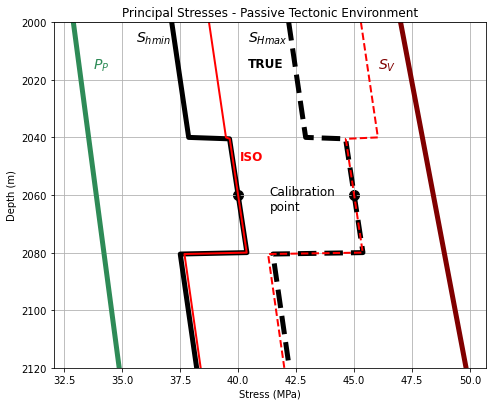

In [16]:
fig, ax = plt.subplots()
plt.plot(Log_PassiveShmin,Log_Depth,'black',linewidth=5)
plt.plot(Log_PassiveSHMax,Log_Depth,'black',linewidth=5,linestyle='dashed')
ax.text(0.45, 0.9, 'TRUE', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',weight='bold')

plt.plot(Log_PassiveIsoShmin,Log_Depth,'red',linewidth=2)
plt.plot(Log_PassiveIsoSHMax,Log_Depth,'red',linewidth=2,linestyle='dashed')
ax.text(0.43, 0.63, 'ISO', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='red',weight='bold')

plt.scatter(PassiveShmin,Log_Depth[Calibrationpoint_index],color='black',s=100)
plt.scatter(PassiveShmax,Log_Depth[Calibrationpoint_index],color='black',s=100)

plt.plot(Log_SV,Log_Depth,'maroon',label='Elastic',linewidth=5)
plt.plot(Log_PP,Log_Depth,'seagreen',label='Elastic',linewidth=5)
ax.text(0.75, 0.9, '$S_{V}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='maroon',weight='bold')
ax.text(0.09, 0.9, '$P_{P}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='seagreen',weight='bold')
ax.text(0.19, 0.98, '$S_{hmin}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='black')
ax.text(0.45, 0.98, '$S_{Hmax}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='black')
ax.text(0.5, 0.53, '{}\n{}'.format('Calibration','point'), transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black')

plt.ylim(max(Log_Depth), min(Log_Depth))
plt.grid()
plt.title('Principal Stresses - Passive Tectonic Environment')
plt.xlabel('Stress (MPa)'); plt.ylabel('Depth (m)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.2, wspace=0.5, hspace=0.5)

Analysis under active tectonic environments shows that the risk of tectonic environments and principal stresses overestimation along the isotropic section is possible.
Along active tectonic intervals, stress bias due to assumptions of isotropy along VTI intervals is low. However, the risk of assuming isotropic intervals as (non-existent) barriers increases.

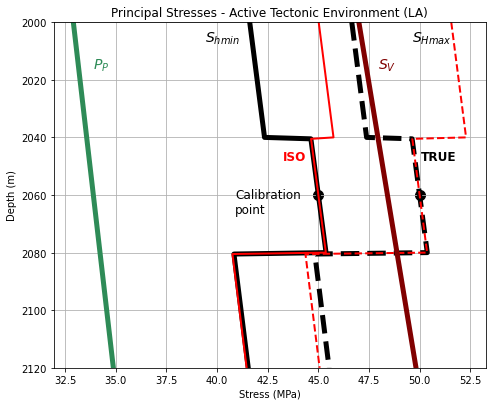

In [17]:
fig, ax = plt.subplots()
plt.plot(Log_ActiveLAShmin,Log_Depth,'black',linewidth=5)
plt.plot(Log_ActiveLASHMax,Log_Depth,'black',linewidth=5,linestyle='dashed')
ax.text(0.85, 0.63, 'TRUE', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',weight='bold')

plt.plot(Log_ActiveLAIsoShmin,Log_Depth,'red',linewidth=2)
plt.plot(Log_ActiveLAIsoSHMax,Log_Depth,'red',linewidth=2,linestyle='dashed')
ax.text(0.53, 0.63, 'ISO', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='red',weight='bold')

plt.scatter(ActiveLAShmin,Log_Depth[Calibrationpoint_index],color='black',s=100)
plt.scatter(ActiveLAShmax,Log_Depth[Calibrationpoint_index],color='black',s=100)

plt.plot(Log_SV,Log_Depth,'maroon',label='Elastic',linewidth=5)
plt.plot(Log_PP,Log_Depth,'seagreen',label='Elastic',linewidth=5)
ax.text(0.75, 0.9, '$S_{V}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='maroon',weight='bold')
ax.text(0.09, 0.9, '$P_{P}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='seagreen',weight='bold')
ax.text(0.35, 0.98, '$S_{hmin}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='black')
ax.text(0.83, 0.98, '$S_{Hmax}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='black')
ax.text(0.42, 0.52, '{}\n{}'.format('Calibration','point'), transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black')
plt.grid()
plt.ylim(max(Log_Depth), min(Log_Depth))
plt.title('Principal Stresses - Active Tectonic Environment (LA)')
plt.xlabel('Stress (MPa)'); plt.ylabel('Depth (m)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.2, wspace=0.5, hspace=0.5)

This effects are present both for LA and HA.

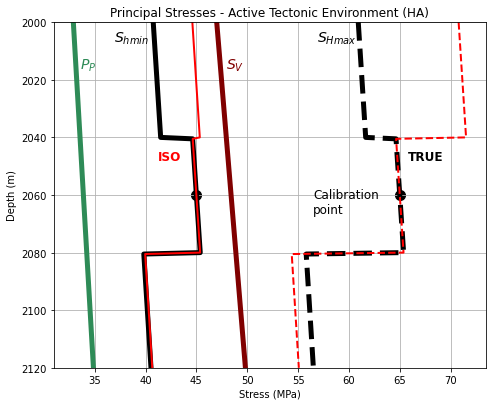

In [18]:
fig, ax = plt.subplots()
plt.plot(Log_ActiveHAShmin,Log_Depth,'black',linewidth=5)
plt.plot(Log_ActiveHASHMax,Log_Depth,'black',linewidth=5,linestyle='dashed')
ax.text(0.82, 0.63, 'TRUE', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black',weight='bold')

plt.plot(Log_ActiveHAIsoShmin,Log_Depth,'red',linewidth=2)
plt.plot(Log_ActiveHAIsoSHMax,Log_Depth,'red',linewidth=2,linestyle='dashed')
ax.text(0.24, 0.63, 'ISO', transform=ax.transAxes, fontsize=12, verticalalignment='top',color='red',weight='bold')

plt.scatter(ActiveHAShmin,Log_Depth[Calibrationpoint_index],color='black',s=100)
plt.scatter(ActiveHAShmax,Log_Depth[Calibrationpoint_index],color='black',s=100)

plt.plot(Log_SV,Log_Depth,'maroon',label='Elastic',linewidth=5)
plt.plot(Log_PP,Log_Depth,'seagreen',label='Elastic',linewidth=5)
ax.text(0.4, 0.9, '$S_{V}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='maroon',weight='bold')
ax.text(0.06, 0.9, '$P_{P}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='seagreen',weight='bold')
ax.text(0.14, 0.98, '$S_{hmin}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='black')
ax.text(0.61, 0.98, '$S_{Hmax}$', transform=ax.transAxes, fontsize=14, verticalalignment='top',color='black')
ax.text(0.6, 0.52, '{}\n{}'.format('Calibration','point'), transform=ax.transAxes, fontsize=12, verticalalignment='top',color='black')
plt.grid()
plt.ylim(max(Log_Depth), min(Log_Depth))
plt.title('Principal Stresses - Active Tectonic Environment (HA)')
plt.xlabel('Stress (MPa)'); plt.ylabel('Depth (m)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.2, wspace=0.5, hspace=0.5)